# Investigating the medical appointment no-show trends

The following dataset collects information from 100,000 medical appointments taking place over three spring months of 2016 in Brazil. The data set is focused on the attendance of patients and their characteristics, such as gender, age, date of appointment, health conditions, medical scholarship, SMS reminders, etc. A number of characteristics of the patient are included in each row.

In the following report I will analyse several factors and determine whether those may affect attendance of patients to their scheduled medical appointments: 
- Age
- Long-term health condition or disability
- Medical Scholarship
- Waiting time for scheduled appointment if it was booked in advance
- SMS reminders

In [1]:
# Import all the packages to be used in this project
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

## Data Wrangling

**Findings:** Having initially investigated the original data I found that it is a very clean data set with the total of 110,527 entries and 14 columns. There are no duplicates or missing values.  
  There are some discrepancies in data which will need to be dealt with: column headers to be corrected, date columns to be converted into 'datetime' for ease of analysis, some out-of-bounds values to be either removed or swapped for consistency.   
  Additionally, there should be new data columns created for more insight.  

### General Properties

In [2]:
# Load original file and see first lines
raw_df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
raw_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
# View overall information about the data frame
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [4]:
# Check for any outliners minimums and maximums or unexpected values
raw_df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [5]:
# Look for any duplicates
raw_df.duplicated().sum()

0

In [6]:
# Check for missing values for each feature
raw_df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [7]:
# Number of non-null unique values
raw_df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

### Data Cleaning
In order to perform a thorough analysis, I will be taking following steps to clean the data and then save it to a new file ready for EDA and visualisations.
- Clean Table headers, improve any header spelling and errors.
- Column 'Handicap' has more values than just 0 and 1, my assumption is that it shows the number of handicap conditions per person. However, according to the data dictionary on [Kaggle.com](https://www.kaggle.com/joniarroba/noshowappointments "No-Show Appointments") it should be either True or False, same as other columns with health conditions. For the convenience of this analysis, I will replace any other numerical values to 1 and leave 0 values as they are, meaning that a person either has a disability or doesn't.
- There is 1 person with a negative age, and their real age is unknown. Remove unrealistic age of -1, even though it is likely for the person to be 115 years old, it is impossible to be -1.
- Looking at the original data - AppointmentDay does not have any information for the time of appointments, while ScheduledDay does. It would not be very informative to analyse during which time of the day the appointments were originally booked, as this is not likely to affect the attendance, so I will drop the time data and only analyse the dates. 'ScheduledDay' and 'AppointmentDay' data formats need to be changed to YYYY-MM-DD.
- Create additional columns:  
  **'No_shows_b'** no-show data converted to binary, for visualisation.  
  **'Waiting_time'** will demonstrate the time delta from Scheduled Appointment and actual Appointment Date.
- For this analysis, only the following original data columns will be required: Age, Scholarship, Long-term conditions, SMS-received and No-Show.

Errors and inconsistencies in column names.

In [8]:
raw_df.rename(columns={'Handcap':'Handicap', 
                       'Hipertension':'Hypertension',
                       'No-show':'No_show'},inplace=True)

Column 'Handicap'

In [9]:
# Note original code for masking: https://stackoverflow.com/questions/21608228/conditional-replace-pandas
mask = raw_df.Handicap > 1
raw_df.loc[mask, 'Handicap'] = 1

Unrealistic age of -1

In [10]:
# Remove the error entry
raw_df = raw_df[raw_df.Age != -1]

Date columns

In [11]:
# Strip the data of time values
raw_df['ScheduledDay'] = raw_df['ScheduledDay'].str.split('T').str[0]
raw_df['AppointmentDay'] = raw_df['AppointmentDay'].str.split('T').str[0]

In [12]:
# Convert Date colums to Datetime
raw_df['ScheduledDay'] = pd.to_datetime(raw_df['ScheduledDay']);
raw_df['AppointmentDay'] = pd.to_datetime(raw_df['AppointmentDay']);

Additional columns.

In [13]:
# Note original code for use of conditional formulas in single line
# https://stackoverflow.com/questions/14714181/conditional-logic-on-pandas-dataframe
raw_df['No_show_b'] = raw_df.No_show.apply(lambda x: 0 if(x=='No') else 1)

In [14]:
raw_df['Waiting_time'] = (raw_df['AppointmentDay'] - raw_df['ScheduledDay']).dt.days

In [15]:
# Ensure there are no negative Awaiting times
raw_df = raw_df[raw_df.Waiting_time >= 0]

Drop unnessesary columns

In [16]:
raw_df.drop(['PatientId','AppointmentID','Gender','Neighbourhood','AppointmentDay','ScheduledDay'], axis=1, inplace=True)

Binning to make the data visualisation less crowded.

In [17]:
# From 0 to 1+ will be a day's wait, followed by within a week, within two weeks (Fortnight), 
# within 30 days (Month), within 3 months (Trimester), within 6 months (Half Year), maximum waiting time here is 176 days.
# Note original code for binning: https://stackoverflow.com/questions/47040238/cleanest-way-to-bin-using-pandas-cut
break_points = [-1,1,7,14,30,90,182]
labels_period = ["Day","Week", "Fortnight", "Month", "Trimester", "Half year"]
time_bins = pd.cut(raw_df.Waiting_time, break_points, labels=labels_period)
raw_df['Waiting_period'] = time_bins

# In the similar manner bin ages into Age Groups
break_points = [0,2,6,12,18,30,65,120]
labels_age = ["Infant","Toddler","Child","Teenager","Young adult","Adult","Elder"]
age_bins = pd.cut(raw_df.Age,break_points,labels=labels_age)
raw_df['Age_group'] = age_bins

Finally save the clean dataframe to a new file

In [18]:
raw_df.to_csv('clean_nsa.csv', index=False)

## Exploratory Data Analysis
In this section I will analyse and visualise data with respect to following questions:
1. People of which ages are more prone to miss an appointment?
2. Are people with certain health conditions more likely to miss an appointment?
3. Is attendance better among patients who are sponsored through a medical scholarship?
4. Are SMS notifications an effective way of boosting attendance?
5. If the appointment has been booked in advance are patients more likely to forget about it?

Most of the provided data is categorical, which means it collects values that are either True or False. For categorical data analysis, simple proportion comparison is the best option. Thus I will mostly use Bar graphs and Histograms for this analysis.

## Baseline analysis

In [19]:
# Load clean data frame and check if all the columnt are in place
df = pd.read_csv('clean_nsa.csv')
df.head(2)

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,No_show_b,Waiting_time,Waiting_period,Age_group
0,62,0,1,0,0,0,0,No,0,0,Day,Adult
1,56,0,0,0,0,0,0,No,0,0,Day,Adult


First of all, let's see how does the no-show data look.  
  There is about 20% of patients who do not attend the appointments with doctors, which were booked. I will use this proportion as a baseline and a deviation from it may be considered a factor affecting the attendance.

In [20]:
# Percentage of no-shows from total amount of appointments
# To see the exact number of missed appointments, 
# filter each attendance status, and use this data to determine percentage
missed = df.loc[df.No_show == 'Yes']
attend = df.loc[df.No_show == 'No']
proportion = len(missed)/(len(missed)+len(attend))*100

print(("Proportion of missed appointments: {} %").format(proportion))

Proportion of missed appointments: 20.18982817745044 %


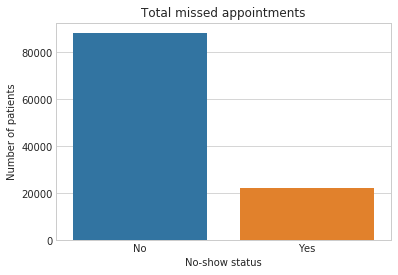

In [22]:
# Visualising the above proportion
g = sns.countplot(x='No_show', data = df)
g.set(title="Total missed appointments", xlabel='No-show status', ylabel='Number of patients');

### 1.  Age 
People of which ages are more prone to miss an appointment?  
**Findings:** Looking at Graphs 1 and 2, the majority of patients are less than 60 years old. The largest age group by count is adults, followed by young adults in their 20s.  
  The no-show rates per age group are illustrated in Graph 3, which show that teenagers miss the doctor's appointments most often, 26% no-shows, they are followed by young adults and children at 23% each. In contrast, infants and elderly people over 65 are very good at keeping their attendance to the doctor.

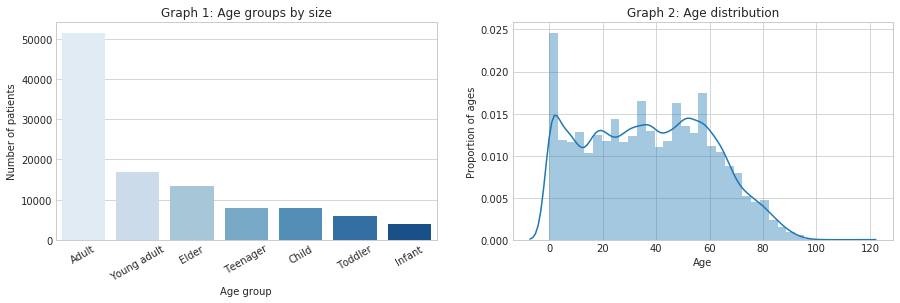

In [23]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1) 
# Note original code for plotting two seaborn graphs side by side - but there should be a more elegant way!
# But so far this is the only way that works and one which I understand :)
# https://stackoverflow.com/questions/42818361/how-to-make-two-plots-side-by-side-using-python

# Visualising number of patients per age group
g_1 = sns.countplot(x='Age_group', data = df, palette='Blues',order=df['Age_group'].value_counts().index)
g_1.set(title="Graph 1: Age groups by size", xlabel='Age group', ylabel='Number of patients')
plt.xticks(rotation=30)

# Distribution of Age
plt.subplot(1, 2, 2)
g_2 = sns.distplot(df['Age'], bins=35) # five bins per each age group
g_2.set(title='Graph 2: Age distribution', xlabel='Age', ylabel='Proportion of ages');

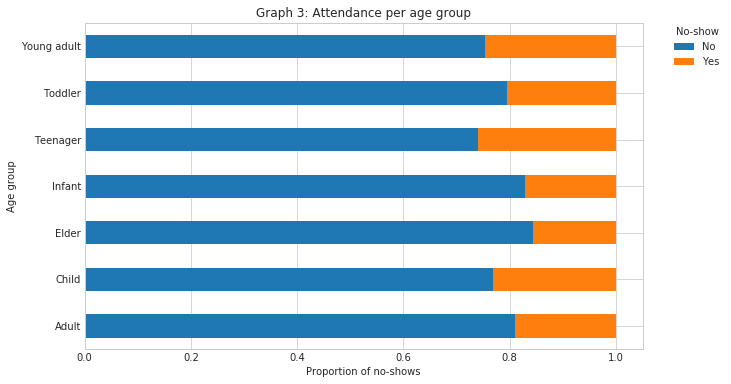

In [24]:
# percentage for show and no_show per each age group.
g_3 = pd.crosstab(df.Age_group, df.No_show, normalize = 'index') 
ax = g_3.plot(kind='barh', stacked=True, figsize=(10,6), title = 'Graph 3: Attendance per age group')
ax.set_xlabel('Proportion of no-shows')
ax.set_ylabel('Age group')
# Original code for the legend: https://matplotlib.org/users/legend_guide.html
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = 'No-show');

### 2 Physical disabilities or health conditions
Visualisation of physical disabilities or health conditions data needs a bit more work. First of all, I will create a pivot table with aggregate no-show data for each health condition.  
  **Findings:** Looking at graphs in figure 4, there is only a slight difference between them, it appears that people suffering from alcoholism miss their appointments slightly more often: 20% from total booked appointments among people with alcoholism are no-shows. In contrast, people with hypertension, for whom there are a lot more appointments, only miss 17% of those.   
  Considering that proportions of no-shows among people with health conditions and disabilities do not deviate much from the baseline, this may not be considered a factor to affect probability of no-shows.

In [25]:
# Using Pivot table to see the overal No-show numbers per dissability
# Note original code for pivot tables - https://pandas.pydata.org/pandas-docs/stable/reshaping.html
conditions = pd.pivot_table(df, values=['Hypertension',
                                     'Diabetes',
                                     'Alcoholism',
                                     'Handicap'],
                       columns='No_show',aggfunc=np.sum)
# Add no show proportion based on first two columns
conditions['No_show_rate'] = (conditions['Yes'] / (conditions['Yes'] + conditions['No']))*100
conditions.head()

No_show,No,Yes,No_show_rate
Alcoholism,2683,677,20.148810
Diabetes,6513,1430,18.003273
Handicap,1834,405,18.088432
Hypertension,18029,3772,17.301959


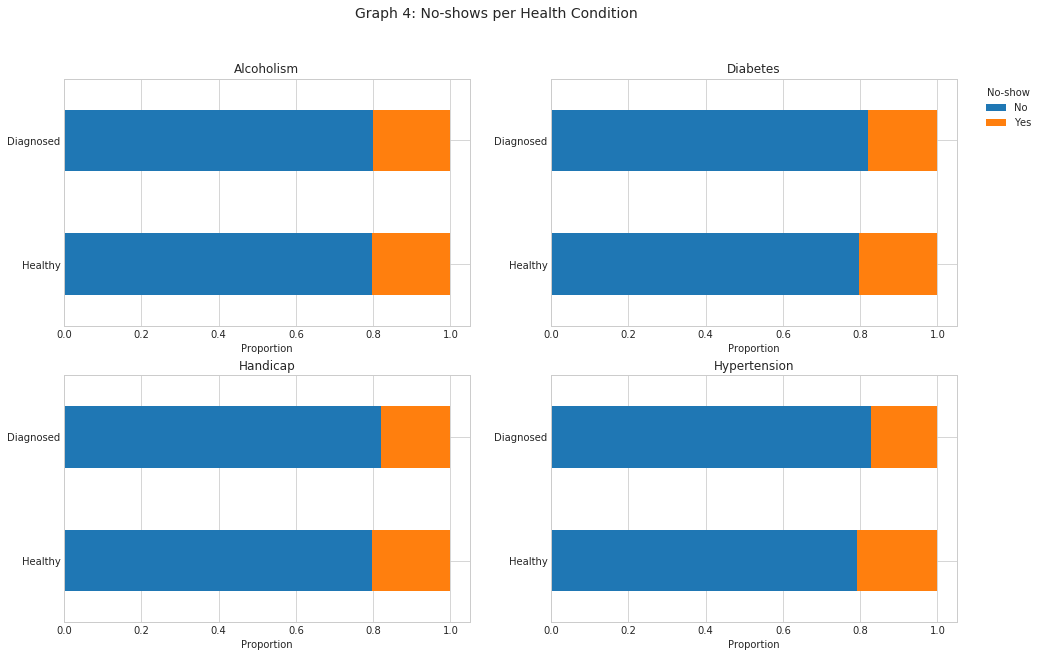

In [26]:
# Note original code for crosstab and subplots: http://photo.etangkk.com/Python/blog-03.asp
# crosstab function has a very convenient parameter 'normalise',
# which calculates proportions
g_4_1 = pd.crosstab(df.Alcoholism, df.No_show, normalize = 'index')
g_4_2 = pd.crosstab(df.Diabetes, df.No_show, normalize = 'index') 
g_4_3= pd.crosstab(df.Handicap, df.No_show, normalize = 'index') 
g_4_4 = pd.crosstab(df.Hypertension, df.No_show, normalize = 'index') 

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
ax = g_4_1.plot(ax=axes[0,0], kind='barh', stacked=True, title = 'Alcoholism', legend = False)
ax = g_4_2.plot(ax=axes[0,1], kind='barh', stacked=True, title = 'Diabetes', legend = False)
ax = g_4_3.plot(ax=axes[1,0], kind='barh', stacked=True, title = 'Handicap', legend = False)
ax = g_4_4.plot(ax=axes[1,1], kind='barh', stacked=True, title = 'Hypertension', legend = False)
plt.setp(axes,yticklabels=['Healthy', 'Diagnosed'], xlabel = 'Proportion', ylabel='')
plt.legend(bbox_to_anchor=(1.05, 2.2), loc=2, title = 'No-show')
plt.suptitle('Graph 4: No-shows per Health Condition', fontsize=14);

### 3. Medical Scholarship
Scholarship refers to money that is granted to patients who are enrolled in Brasilian welfare program Bolsa Família and are unable to pay for doctor's appointments.
I will also analyse this data in perspective with age groups and determine whether being sponsored may affect attendance to their medical appointments.  
**Findings:**  There is 10,861 patients or about 10% who have scholarships. From Graph 5 it is observed that most of patiens receivng scholarships are in the Adult age group. It is also observed that there is a slightly bigger proportion of no-shows among people receiving medical scholarships.
Yound adults and teenagers being sponsored miss their appointments most often at 27% no-shows, in the largest sponsored age group - Adults, 22% of appointments are missed, while only 13% of sponsored infants miss their appointments.

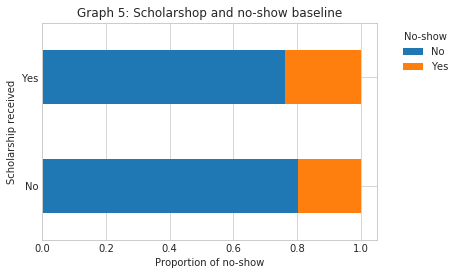

In [32]:
# Visualising total no-show proportion amonth patients with scholarship
g_5 = pd.crosstab(df.Scholarship, df.No_show, normalize = 'index')
ax = g_5.plot(kind='barh', stacked=True, title='Graph 5: Scholarshop and no-show baseline')
plt.setp(ax,yticklabels=['No', 'Yes'], xlabel='Proportion of no-show', ylabel='Scholarship received')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title = 'No-show');

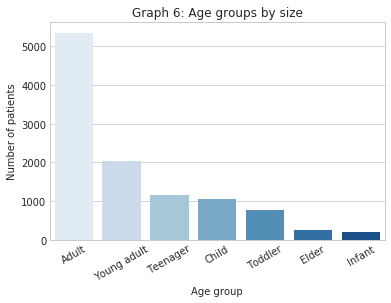

In [33]:
# Filter out population paying for their appointments
# and create new table to see which age groups receive sponsorship
sponsored = df.loc[df.Scholarship == 1,['Scholarship','Age_group','No_show']]

# Visualisation of age props distribution among people with medical scholarship
g_6 = sns.countplot(x='Age_group', data = sponsored, palette='Blues', order=sponsored['Age_group'].value_counts().index)
g_6.set(title='Graph 6: Age groups by size', xlabel='Age group', ylabel='Number of patients')
plt.xticks(rotation=30);

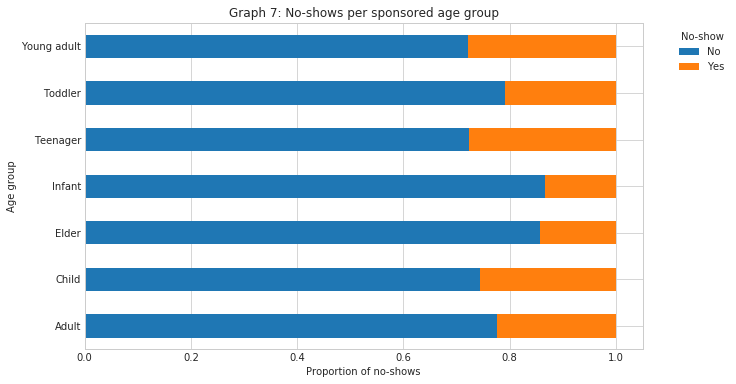

In [30]:
# Visualising age groups by scholarship count
g_7 = pd.crosstab(sponsored.Age_group, sponsored.No_show, normalize = 'index') 
g_7.plot(kind='barh', stacked=True, figsize=(10,6), title='Graph 7: No-shows per sponsored age group')
plt.xlabel('Proportion of no-shows')
plt.ylabel('Age group')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title='No-show');

### 3. Waiting time for the appointment
Whether an appointment was booked in advance should play a considerable role in the probability of no-show.  
  **Findings:** From distribution Graph 8 it is apparent that vast majority of appointments are for within one day of booking time.  
  The no-show rate is very low for patients attending doctor's appointment within a day as represented in Graph 9. However no-shows become much more frequent for appointments booked a week in advance, and the highest no-show rate is observed for appointments booked 3 months in advance. Note: in Graph 18 data for 'Half year' is biased, due to a very small sample size.

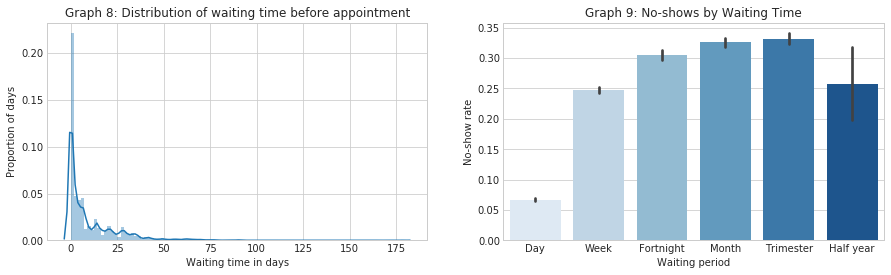

In [35]:
# Distribution of Waiting time
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
g_8 = sns.distplot(df['Waiting_time'], bins=100)
g_8.set(title='Graph 8: Distribution of waiting time before appointment', xlabel='Waiting time in days', ylabel='Proportion of days');

# Waiting time bar chart
plt.subplot(1, 2, 2)
g_9 = sns.barplot(x='Waiting_period', y='No_show_b', data = df, palette='Blues')
g_9.set(title='Graph 9: No-shows by Waiting Time',xlabel='Waiting period', ylabel='No-show rate');

### 4. SMS reminders
SMS reminders are widely used to boost the attendance rate.  
**Findings:** A third of all patients waiting for an appointment have received SMS reminders.
As expected, the reminders were sent to those patients whose appointments were scheduled 2 or more days in advance.
From Graph 10 it can be observed that there is a lower rate of no-shows if a patient has received a reminder. Graph 11 demonstrates that there is still a rise in no-shows over time dispite the reminders.

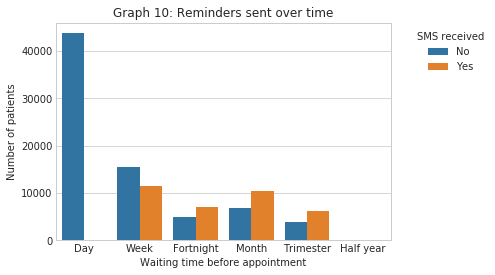

In [38]:
# Distribution of SMS reminders
g_10 = sns.countplot(x='Waiting_period', hue= 'SMS_received', data=df)
g_10.set(title='Graph 10: Reminders sent over time', xlabel='Waiting time before appointment', ylabel='Number of patients')
plt.legend(['No','Yes'], bbox_to_anchor=(1.05, 1), loc=2, title='SMS received');

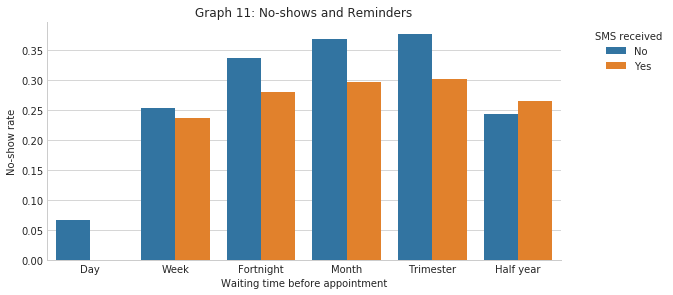

In [39]:
g_11 = sns.factorplot(x='Waiting_period', y='No_show_b', hue='SMS_received', data=df, kind='bar', 
                     size = 4, aspect = 2, legend=False, ci=None)
g_11.set(title='Graph 11: No-shows and Reminders', xlabel='Waiting time before appointment', ylabel='No-show rate')
plt.legend(['No','Yes'], bbox_to_anchor=(1.05, 1), loc=2, title='SMS received');

## Conclusions
According to this particular data set, there are following conclusions:
- Certain age groups such as Teenagers and Young adults may be considered to be a factor to the probability of no-shows.
- A long-term health condition or disability does not have a big effect on the probability of medical no-shows in this dataset.
- Medical Scholarship yielded interesting results, as people with scholarships tend to miss their appointments more, according to this dataset.
- Waiting time for scheduled appointment does have an effect on the probability of attendance, the more time passes between booking date and appointment, the fewer people show up.
- SMS reminders do have a slight effect on attendance, however, with time they become less effective.


Limitations:
- Larger sample size (over 100k entries) would have allowed performing more undistorted analysis in multiple dimensions, such as no-shows comparison between age groups with certain health conditions.
- Longer time set (for a period of 12 months or more) would have allowed observing if there are any seasonal dependencies. For example, if people with certain health conditions are attending more during a certain season, or if the attendance drops during particularly rainy or hot months.
- Information about who booked an appointment, e.g. the doctor, patient, or it was a routine/recurring booking. These factors could also play a role in probability of no-shows.
- It would be interesting to investigate whether there were a certain number of SMS reminders, as sending more frequent notifications, logically, could have an effect on attendance.

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])